
# Training a MNIST Classifier

There are many examples of how to train a MNIST with PyTorch. This notebook broken up into 7 easy steps.

1. Import your libraries
2. Load the Dataset & Make the Dataset Iterable
3. Visualize the Data
4. Define the Network
5. Define Loss Function and Optimizer
6. Train the network
7. Save the model


# Step 1:Import the libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)
!nvidia-smi

1.6.0+cu101
0.7.0+cu101
Fri Oct 23 08:23:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

# Step 2:  Load the Dataset & Make the Dataset Iterable


In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Download the training datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
# Make the Dataset Iterable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Download the test datasets
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
# Make the Dataset Iterable
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Step 3: Visualize the Data

In [ ]:
# How long is the dataset
len(trainset)

60000

In [ ]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


## Display a grid of images
Let us show some of the training images.



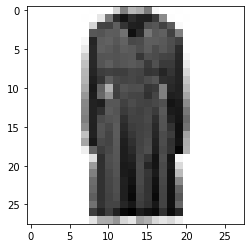

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Display a single image
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys') #Greys_r

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([3, 0, 0, 2, 9, 3, 8, 5, 0, 0, 4, 9, 9, 3, 6, 2, 4, 6, 4, 0, 6, 7, 7, 6,
        5, 5, 7, 1, 8, 6, 3, 5, 9, 3, 2, 5, 8, 8, 0, 7, 3, 8, 3, 1, 1, 7, 8, 9,
        1, 4, 8, 1, 1, 3, 5, 0, 3, 5, 1, 1, 4, 2, 7, 4])


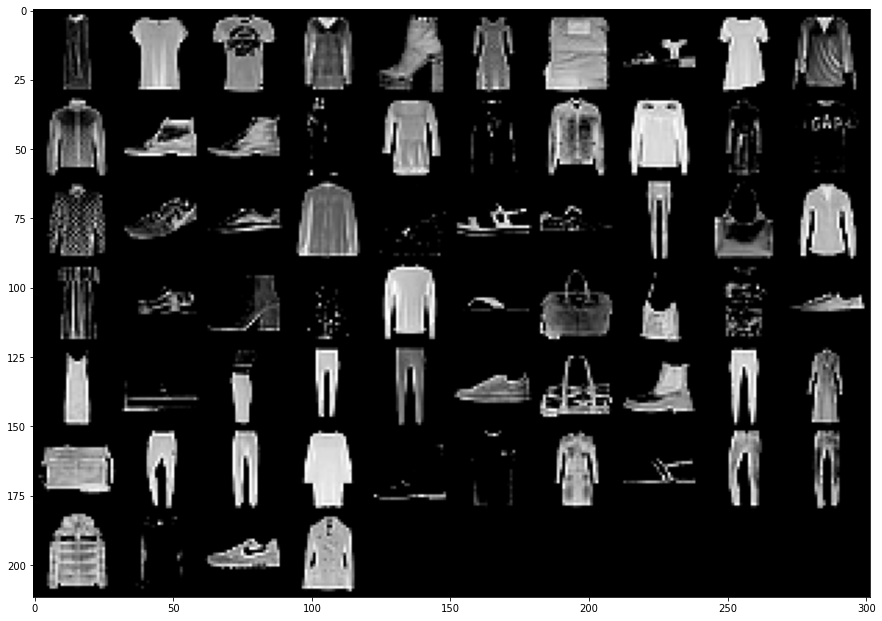

In [ ]:
# Lets look at some more data

sample= next(iter(trainloader)) # train_loader will produce more images
images, labels= sample
grid= torchvision.utils.make_grid(images, nrow= 10)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels:', labels)

## Using Matplotlib

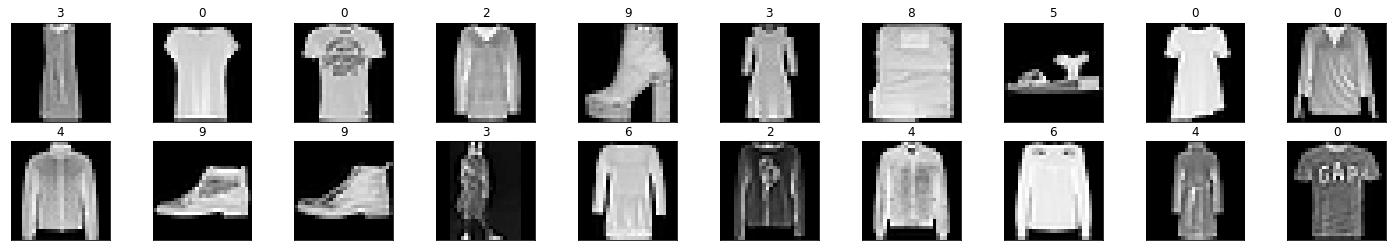

In [ ]:
# Lets use matplotlib to diplay the grid aswell

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Display detailed image

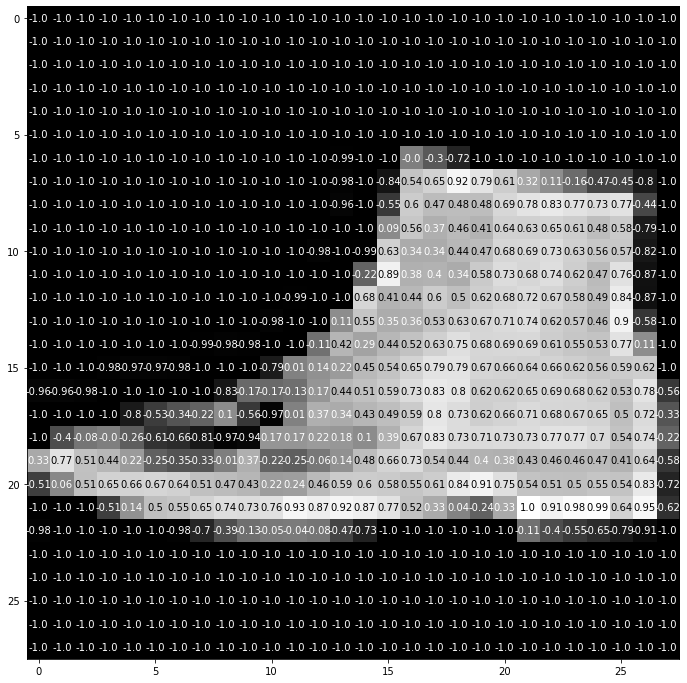

In [ ]:
# View an Image in More Detail
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Step 4: Define the Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Step 5: Define Loss Function and Optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Step 6: Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(10):  
    running_loss = 0.0
    running_correct = 0
    for data in (trainloader):
        # get the images and labels
        inputs, labels = data
        # set the parameter gradients to zero
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()
        
    print(f"Epoch {epoch+1} train loss: {running_loss/len(trainset):.3f} train acc: {running_correct/len(trainset)}")
print('Finished Training')

Epoch 1 train loss: 0.031 train acc: 0.26525
Epoch 2 train loss: 0.012 train acc: 0.71625
Epoch 3 train loss: 0.010 train acc: 0.75895
Epoch 4 train loss: 0.009 train acc: 0.7848833333333334
Epoch 5 train loss: 0.008 train acc: 0.8039666666666667
Epoch 6 train loss: 0.008 train acc: 0.819
Epoch 7 train loss: 0.007 train acc: 0.83375
Epoch 8 train loss: 0.007 train acc: 0.8415666666666667
Epoch 9 train loss: 0.006 train acc: 0.85115
Epoch 10 train loss: 0.006 train acc: 0.85695
Finished Training


# Step 7: Save the model
Let's quickly save our trained model:



In [ ]:
PATH = './MNIST.pth'
torch.save(net.state_dict(), PATH)